<a href="https://colab.research.google.com/github/zxbi/IST597_22SP/blob/main/HW00100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import time

%matplotlib inline
%pip install mlxtend --upgrade

     |████████████████████████████████| 1.3 MB 5.0 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


Let's configure all random numbers generators to support determinism and obtain reproducible results.

Initializing parameters

In [ ]:
dropout_p=0.1
seed=2222
np.random.seed(seed)
tf.random.set_seed(seed)

size_input = 28*28
size_hidden_1 = 256
size_hidden_2 = 128
size_output = 10
batch_size=30
lr=0.001
dropout_p=0.1
L1=0
L2=3e-5

# Load Data

Keras comes with the MNIST data loader. Keras has a function `mnist.load_data()` which downloads the data from its servers if it is not present already. The data loaded using this function is divided into training and test sets.

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
#fashion_mnist = tf.keras.datasets.fashion_mnist

11501568/11490434 [==============================] - 0s 0us/step


# Checkout the data

The data consists of handwritten numbers ranging from 0 to 9, along with their ground truth. It has 60,000 train samples and 10,000 test samples. Each sample is a 28x28 grayscale image.

In [ ]:
from tensorflow.keras.utils import to_categorical

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : 7')

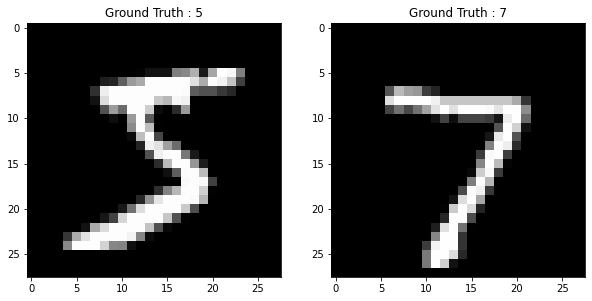

In [ ]:
print('Training data shape : ', train_images.shape, train_labels.shape)

print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
classes_num = len(classes)
print('Total number of outputs : ', classes_num)
print('Output classes : ', classes)

plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))


# Process the data

* The images are grayscale and the pixel values range from 0 to 255.
* Convert each image matrix ( 28x28 ) to an array ( 28*28 = 784 dimenstional ) which will be fed to the network as a single feature.
* We convert the data to float and **scale** the values between 0 to 1.
* We also convert the labels from integer to **categorical ( one-hot ) encoding** since that is the format required by Keras to perform multiclass classification. One-hot encoding is a type of boolean representation of integer data. It converts the integer to an array of all zeros except a 1 at the index of the number. For example, using a one-hot encoding of 10 classes, the integer 5 will be encoded as 0000010000

In [ ]:
# Scale the data to lie between 0 to 1
#train_data /= 255
#test_data /= 255
#val_data = train_data[-10000:]
#val_labels = train_labels[-10000:]



#(x_train, y_train), (x_test, y_test) = fashion_mnist
(x_train, y_train), (x_test, y_test) = (train_images, train_labels), (test_images, test_labels) 
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train=tf.reshape(x_train,[x_train.shape[0],-1])
x_test=tf.reshape(x_test,[x_test.shape[0],-1])

x_train, x_valid = tf.split(x_train,num_or_size_splits=[55000, 5000],axis=0)
y_train, y_valid = tf.split(y_train, num_or_size_splits=[55000, 5000], axis=0)


In [ ]:
from keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Create the network

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
   # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))



    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden]))



    # Initialize weights between hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3,self.W4, self.b1, self.b2,self.b3,self.b4]

    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred_tf, labels= y_true_tf))
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-02, beta_1=0.9, beta_2=0.99, epsilon=1e-02)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
    
 
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #X_tf = X_tf/np.linalg.norm(X_tf)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)


    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)

    what_3 = tf.matmul(hhat_2, self.W3) + self.b3
    hhat_3 = tf.nn.relu(what_3)
    # Compute output
    output = tf.matmul(hhat_3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Define class to build mlp model
from tensorflow.python.ops.gen_nn_ops import l2_loss
class MLP_L2(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
   # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden]))


     # Initialize weights between hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3,self.W4, self.b1, self.b2,self.b3,self.b4]


    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    lambd = 1e-5
    m = y_true.shape[1]
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    l2_loss = tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.b1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(self.b2) + tf.nn.l2_loss(self.W3) + tf.nn.l2_loss(self.b3) + tf.nn.l2_loss(self.W4) + tf.nn.l2_loss(self.b4)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred_tf, labels= y_true_tf)) + 0.0005*l2_loss
    
    return loss

  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-02, beta_1=0.9, beta_2=0.99, epsilon=1e-02)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

   
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer

    #X_tf = X_tf/np.linalg.norm(X_tf)

    what = tf.matmul(X_tf, self.W1) + self.b1
    #what = np.linalg.norm(tf.matmul(X_tf, self.W1) + self.b1)
    hhat = tf.nn.relu(what)
    #hhat = np.linalg.norm(tf.nn.relu(what))

  
    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)
    #hhat_2 = np.linalg.norm(tf.nn.relu(what_2))

    what_3 = tf.matmul(hhat_2, self.W3) + self.b3
    hhat_3 = tf.nn.relu(what_3)
    #hhat = np.linalg.norm(tf.nn.relu(what_3))

    # Compute output
    output = tf.matmul(hhat_3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output 

In [ ]:
# Define class to build mlp model
from tensorflow.python.ops.gen_nn_ops import l2_loss
class MLP_L2_vanilla(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
   # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden]))


     # Initialize weights between hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3,self.W4, self.b1, self.b2,self.b3,self.b4]


    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    lambd = 1e-5
    m = y_true.shape[1]
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    l2_loss = tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.b1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(self.b2) + tf.nn.l2_loss(self.W3) + tf.nn.l2_loss(self.b3) + tf.nn.l2_loss(self.W4) + tf.nn.l2_loss(self.b4)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred_tf, labels= y_true_tf)) + 0.0005*l2_loss
    
    return loss

  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    lr = 1e-4
    dws = grads
    return dws 

  def vanillasgd(self, grads,iter,lr=1e-4, beta_1=0.9,beta_2=0.999, beta_3 = 0.999987, epsilon=1e-8):
    
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in self.variables]
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in self.variables]
    us = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in self.variables]

    updates = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in self.variables]

    counter = 0
    for p, g, m, v, u in zip(self.variables, grads, ms, vs, us):
      #print(type(p))
      m_t = (beta_1 * m) + (1. - beta_1) * g
      v_t = (beta_2 * v) + (1. - beta_2) * g * g 
      u_t = (beta_3 * u) + (1. - beta_3) * g * g* g
          
      m_t_hat = m_t / (1- K.pow(beta_1, iter))
      v_t_hat = v_t / (1- K.pow(beta_2, iter))
      u_t_hat = u_t / (1- K.pow(beta_3, iter))

      p_t_hat = p - lr * m_t_hat / (K.sqrt(v_t_hat) + K.pow(u_t_hat, 1/3) * epsilon)


      K.update(m, m_t_hat)
      K.update(v, v_t_hat)
      K.update(u, u_t_hat)

      p = p_t_hat

      updates.append(p_t_hat)
           
    for i in range(len(self.variables)):
      self.variables[i].assign(updates[i])

        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

   
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer

    #X_tf = X_tf/np.linalg.norm(X_tf)

    what = tf.matmul(X_tf, self.W1) + self.b1
    #what = np.linalg.norm(tf.matmul(X_tf, self.W1) + self.b1)
    hhat = tf.nn.relu(what)
    #hhat = np.linalg.norm(tf.nn.relu(what))

  
    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)
    #hhat_2 = np.linalg.norm(tf.nn.relu(what_2))

    what_3 = tf.matmul(hhat_2, self.W3) + self.b3
    hhat_3 = tf.nn.relu(what_3)
    #hhat = np.linalg.norm(tf.nn.relu(what_3))

    # Compute output
    output = tf.matmul(hhat_3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output 

In [ ]:
# Define class to build mlp model
class MLP_DROPOUT(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
   # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))



    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden]))



    # Initialize weights between hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3,self.W4, self.b1, self.b2,self.b3,self.b4]

    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred_tf, labels= y_true_tf))
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-02, beta_1=0.9, beta_2=0.99, epsilon=1e-02)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
    
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    p= 0.9
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #X_tf = X_tf/np.linalg.norm(X_tf)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1

    hhat = tf.nn.relu(what)
    hhat_drop = tf.nn.dropout(hhat, 0.1)

    


    what_2 = tf.matmul(hhat_drop, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)
    hhat_drop_2 = tf.nn.dropout(hhat_2, 0.1)
    


    what_3 = tf.matmul(hhat_drop_2, self.W3) + self.b3

    hhat_3 = tf.nn.relu(what_3)
    hhat_drop_3 = tf.nn.dropout(hhat_3, 0.1)
    
    # Compute output
    output = tf.matmul(hhat_drop_3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Define class to build mlp model
class MLP_DROPOUT_Vanilla(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
   # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))


    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))


    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden]))


     # Initialize weights between hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3,self.W4,self.b1,self.b2,self.b3,self.W4]
 
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred_tf, labels= y_true_tf))
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    
      #print("VARIABLES:", self.variables)
    grads = tape.gradient(current_loss, self.variables)
    #print("GRADS:", grads)
    dws = grads
    return dws 



  def vanillasgd(self, grads,iter,lr=1e-2, beta_1=0.9,beta_2=0.999, beta_3 = 0.999987, epsilon=1e-8):
    
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in self.variables]
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in self.variables]
    us = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in self.variables]

    updates = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in self.variables]

    counter = 0
    for p, g, m, v, u in zip(self.variables, grads, ms, vs, us):
      #print(type(p))
      m_t = (beta_1 * m) + (1. - beta_1) * g
      v_t = (beta_2 * v) + (1. - beta_2) * g * g 
      u_t = (beta_3 * u) + (1. - beta_3) * g * g* g
          
      m_t_hat = m_t / (1- K.pow(beta_1, iter))
      v_t_hat = v_t / (1- K.pow(beta_2, iter))
      u_t_hat = u_t / (1- K.pow(beta_3, iter))

      p_t_hat = p - lr * m_t_hat / (K.sqrt(v_t_hat) + K.pow(u_t_hat, 1/3) * epsilon)


      K.update(m, m_t_hat)
      K.update(v, v_t_hat)
      K.update(u, u_t_hat)

      p = p_t_hat

      updates.append(p_t_hat)

    Wt = [a_i - b_i for a_i, b_i in zip(self.variables, updates)]
           
    for i in range(len(self.variables)):
      self.variables[i].assign(Wt[i])
      
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    p= 0.9
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    #X_tf = X_tf/np.linalg.norm(X_tf)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    what = what * np.random.binomial(1, p, size = what.shape) /p
    hhat = tf.nn.relu(what)
    hhat_drop = tf.nn.dropout(hhat, 0.1)

    


    what_2 = tf.matmul(hhat_drop, self.W2) + self.b2
    what_2 = what_2 * np.random.binomial(1, p, size = what_2.shape)/p
    hhat_2 = tf.nn.relu(what_2)
    hhat_drop_2 = tf.nn.dropout(hhat_2, 0.1)
    


    what_3 = tf.matmul(hhat_drop_2, self.W3) + self.b3
    what_3 = what_3 * np.random.binomial(1, p, size = what_3.shape) /p
    hhat_3 = tf.nn.relu(what_3)
    hhat_drop_3 = tf.nn.dropout(hhat_3, 0.1)
    
    # Compute output
    output = tf.matmul(hhat_drop_3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
class MLP_Vanilla(tf.keras.Model):
  def __init__(self, size_input, size_hidden_1, size_hidden_2, size_output, device=None):
    super(MLP_Vanilla, self).__init__()
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """

    self.size_input, self.size_hidden_1, self.size_hidden_2, self.size_output, self.device =\
    size_input, size_hidden_1, size_hidden_2, size_output, device

    self.initial=tf.keras.initializers.he_normal(seed=seed)
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(self.initial([self.size_input, self.size_hidden_1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(self.initial([1, self.size_hidden_1]))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(self.initial([self.size_hidden_1, self.size_hidden_2]))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(self.initial([1, self.size_hidden_2]))
     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(self.initial([self.size_hidden_2, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(self.initial([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.MLP_variables = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

    self.loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    self.reg_12=tf.keras.regularizers.L1L2(l1=L1, l2=L2)

    self.t=0
    self.m=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    self.u=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    self.v=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    
  def forward(self, training, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if training==1:
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X)
      else:
        self.y = self.compute_output(X)
    elif training==0:
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output_test(X)
      else:
        self.y = self.compute_output_test(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    return self.loss_object(y_true, y_pred)+self.reg_12(self.W1)+self.reg_12(self.W2)

  def loss2(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    return self.loss_object(y_true, y_pred)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """

    '''
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    with tf.GradientTape() as tape:
      predicted = self.forward(1,X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.MLP_variables)
    optimizer.apply_gradients(zip(grads, self.MLP_variables))
    '''

    self.t=self.t+1
    beta_1=0.9
    beta_2=0.999
    beta_3=0.999987
    ep=0.00000001
    
    with tf.GradientTape() as tape:
      predicted = self.forward(1,X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.MLP_variables)


    self.m=[a_i*beta_1+(1-beta_1)*b_i for a_i, b_i in zip(self.m, grads) ]
    self.u=[a_i*beta_2+(1-beta_2)*(b_i**2) for a_i, b_i in zip(self.u, grads) ]
    self.v=[a_i*beta_3+(1-beta_3)*(b_i**3) for a_i, b_i in zip(self.v, grads) ]

    hm=[a_i/(1-(beta_1**self.t)) for a_i in self.m]
    hu=[a_i/(1-(beta_2**self.t)) for a_i in self.u]
    hv=[a_i/(1-(beta_3**self.t)) for a_i in self.v]
    hv_sign=[tf.math.sign(a_i) for a_i in hv]
    hv_abs=[tf.abs(a_i) for a_i in hv]

    dws_new=[lr * a_i /(ep + tf.sqrt(b_i)+(d_i*tf.pow(c_i,1.0/3.0)*ep)) for a_i, b_i, c_i, d_i in zip(hm, hu, hv_abs,hv_sign)]

    #print(type(dws[0:1]))
    Wt = [a_i - b_i for a_i, b_i in zip(self.variables, dws_new)]
    #print(type(Wt))

    for i in range(len(self.variables)):
      self.variables[i].assign(Wt[i])

        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    hhat = tf.nn.dropout(hhat, rate = dropout_p, seed = seed)
    what_1 = tf.matmul(hhat, self.W2) + self.b2
    hhat_1 = tf.nn.relu(what_1)
    hhat_1 = tf.nn.dropout(hhat_1, rate = dropout_p, seed = seed)
    # Compute output
    what_2 = tf.matmul(hhat_1, self.W3) + self.b3
    #output= tf.nn.softmax(what_2)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return what_2

  def compute_output_test(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    what_1 = tf.matmul(hhat, self.W2) + self.b2
    hhat_1 = tf.nn.relu(what_1)
    # Compute output
    what_2 = tf.matmul(hhat_1, self.W3) + self.b3
    #output= tf.nn.softmax(what_2)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return what_2

Epoch 0, Val Loss: 3.953172445297241, Val Accuracy: 9.5
Epoch 1, Loss: 0.2376898229122162, Accuracy: 92.8472671508789, 
Epoch 2, Loss: 0.08831243962049484, Accuracy: 97.33999633789062, 
Epoch 3, Loss: 0.06050736457109451, Accuracy: 98.19636535644531, 
Epoch 4, Loss: 0.045863788574934006, Accuracy: 98.63091278076172, 
Epoch 5, Loss: 0.037017837166786194, Accuracy: 98.8654556274414, 
Epoch 6, Loss: 0.02964146062731743, Accuracy: 99.10726928710938, 
Epoch 7, Loss: 0.02568388544023037, Accuracy: 99.2036361694336, 
Epoch 8, Loss: 0.021974753588438034, Accuracy: 99.31272888183594, 
Epoch 9, Loss: 0.018130164593458176, Accuracy: 99.43818664550781, 
Epoch 10, Loss: 0.017864134162664413, Accuracy: 99.46908569335938, 
Epoch 11, Loss: 0.014880732633173466, Accuracy: 99.54545593261719, 
Epoch 12, Loss: 0.013863730244338512, Accuracy: 99.60726928710938, 
Epoch 13, Loss: 0.012705345638096333, Accuracy: 99.62000274658203, 
Epoch 14, Loss: 0.012731771916151047, Accuracy: 99.62000274658203, 
Epoch 15, 

Text(0.5, 1.0, 'Train_loss')

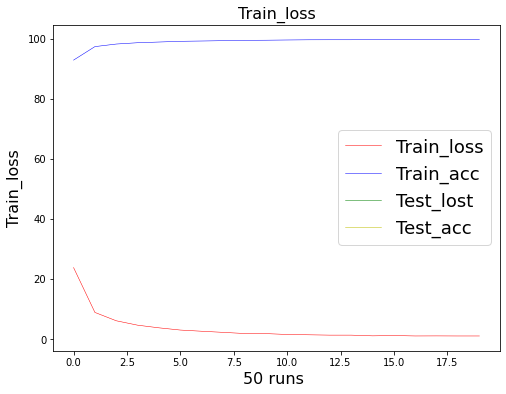

In [13]:
# Set number of epochs
NUM_EPOCHS = 20
# Initialize model using GPU
#mlp_on_gpu = MLP(size_input, size_hidden,size_output, device='gpu') 
#mlp_on_gpu = MLP_L2(size_input, size_hidden,size_output, device='gpu') 
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

train_loss.reset_states()
train_accuracy.reset_states()
val_loss.reset_states()
val_accuracy.reset_states()

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []



mlp_on_default = MLP_Vanilla(size_input, size_hidden_1, size_hidden_2, size_output)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000, seed=seed).batch(batch_size)

for inputs, outputs in valid_ds:
  preds = mlp_on_default.forward(0,inputs)
  val_loss(mlp_on_default.loss2(preds,outputs))
  val_accuracy(outputs, preds)

print(
  f'Epoch {0}, '
  f'Val Loss: {val_loss.result()}, '
  f'Val Accuracy: {val_accuracy.result() * 100}'
)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  
  for inputs, outputs in train_ds:
    mlp_on_default.backward(inputs, outputs)
    preds = mlp_on_default.forward(0,inputs)
    train_loss(mlp_on_default.loss2(preds,outputs))
    train_accuracy(outputs, preds)


  for inputs, outputs in valid_ds:
    preds = mlp_on_default.forward(0,inputs)
    val_loss(mlp_on_default.loss2(preds,outputs))
    val_accuracy(outputs, preds)
  
  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '

  )
  train_accuracy_list.append(train_accuracy.result() * 100)
  train_loss_list.append(train_loss.result() * 100)
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))



test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

test_loss.reset_states()
test_accuracy.reset_states()

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(0,inputs)
  test_loss(mlp_on_default.loss2(preds,outputs))
  test_accuracy(outputs, preds)
  

print(
  f'Epoch {0}, '
  f'Test Loss: {test_loss.result()}, '
  f'Test Accuracy: {test_accuracy.result() * 100}'
)




plt.figure(figsize=[8,6])
plt.plot(train_loss_list,'r',linewidth=0.5)
plt.plot(train_accuracy_list,'b',linewidth=0.5)

plt.plot(test_loss_list,'g',linewidth=0.5)
plt.plot(test_accuracy_list,'y',linewidth=0.5)
#plt.plot(mean3,'g',linewidth=0.5)
plt.legend(['Train_loss','Train_acc','Test_lost','Test_acc'],fontsize=18)
plt.xlabel('50 runs ',fontsize=16)
plt.ylabel('Train_loss',fontsize=16)
plt.title('Train_loss',fontsize=16)